#**Import Libraries**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import jaccard_score, roc_curve, auc

#**Load Dataset**

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.ECBJ4W_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.ECBJ4W_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
       

#**Preprocess Dataset**

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

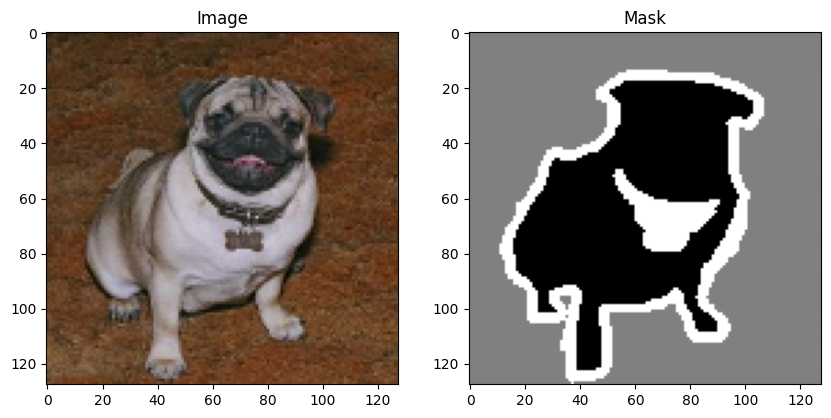

In [ ]:
def load_dataset(split):
    dataset = tfds.load('oxford_iiit_pet', split=split, as_supervised=False)
    return dataset.map(lambda x: (x['image'], x['segmentation_mask']),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = load_dataset('train')
test_dataset = load_dataset('test')

dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=False)
print(info)

def preprocess_image(image, mask):
    if len(image.shape) == 4:
        image = tf.squeeze(image, axis=0)
    if len(mask.shape) == 4:
        mask = tf.squeeze(mask, axis=0)

    image = tf.image.resize(image, (128, 128))
    mask = tf.image.resize(mask, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = image / 255.0

    mask = mask - 1
    mask = tf.cast(mask, tf.int32)

    return image, mask

def process_train_data(dataset):
    return dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

def process_test_data(dataset):
    return dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = process_train_data(train_dataset)
test_dataset = process_test_data(test_dataset)

train_dataset = train_dataset.batch(16).shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(16).prefetch(tf.data.experimental.AUTOTUNE)


for image, mask in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)

for image, mask in train_dataset.take(1):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image[0].numpy())
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask[0].numpy().squeeze(), cmap='gray')
    plt.show()

#**Define U-Net Model**

In [ ]:
def unet_model(input_size=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_size)


    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_17[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_20[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_22[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_24[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_26[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 16, 16,    │  2,097,664 │ conv2d_27[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

#**Train Model**

In [ ]:
model.summary()
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_17[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_20[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_22[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_24[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_26[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 16, 16,    │  2,097,664 │ conv2d_27[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,875 (118.38 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 133s 345ms/step - accuracy: 0.5869 - loss: 0.9068 - val_accuracy: 0.6119 - val_loss: 0.7984
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 88s 284ms/step - accuracy: 0.6558 - loss: 0.7598 - val_accuracy: 0.7477 - val_loss: 0.6178
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 77s 298ms/step - accuracy: 0.7448 - loss: 0.6276 - val_accuracy: 0.7646 - val_loss: 0.5836
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 75s 283ms/step - accuracy: 0.7803 - loss: 0.5569 - val_accuracy: 0.7944 - val_loss: 0.5265
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 73s 281ms/step - accuracy: 0.8077 - loss: 0.4892 - val_accuracy: 0.8177 - val_loss: 0.4781
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 82s 283ms/step - accuracy: 0.8262 - loss: 0.4538 - val_accuracy: 0.8391 - val_loss: 0.4161
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 77s 298ms/step - accuracy: 0.8420 - loss: 0.4142 - val_accuracy: 0.8290 - val_loss: 0.4375
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 76s 298ms/step - accuracy: 0.8459 - loss: 

#**Evaluate and Visualize Predictions**

230/230 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.8609 - loss: 0.3652
Test accuracy: 0.8598659634590149
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


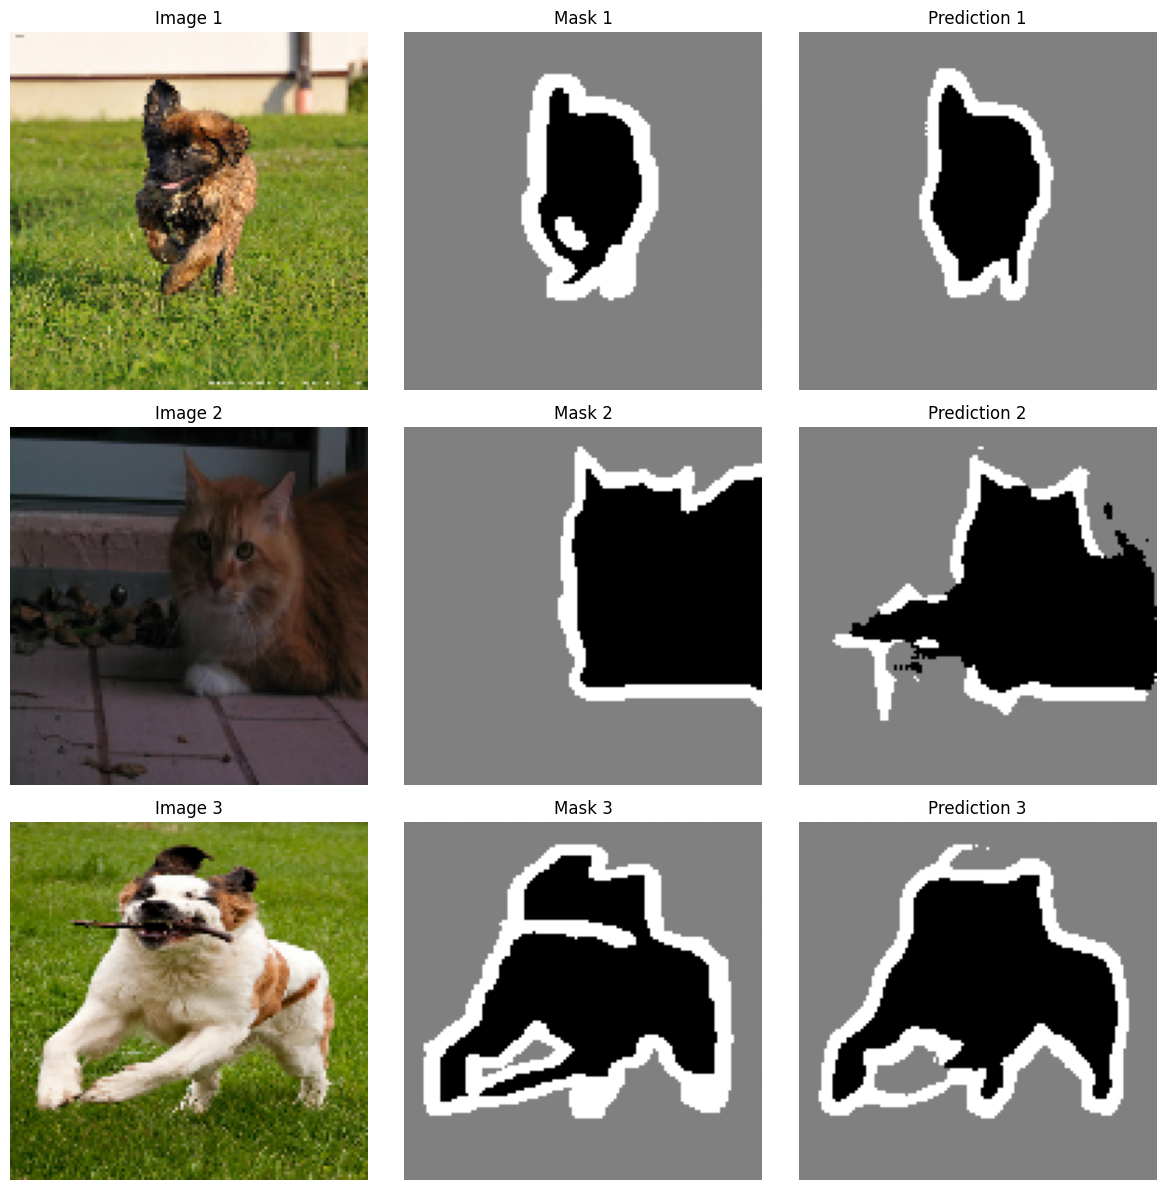

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

sample_image, sample_mask = next(iter(test_dataset))
predictions = model.predict(sample_image)

plt.figure(figsize=(12, 12))
for i in range(3):

    plt.subplot(3, 3, i*3 + 1)
    plt.title(f"Image {i+1}")
    plt.imshow(sample_image[i].numpy())
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.title(f"Mask {i+1}")
    plt.imshow(sample_mask[i].numpy().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.title(f"Prediction {i+1}")
    plt.imshow(predictions[i].argmax(axis=-1), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

#**Calculate IoU and ROC Curves**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
IoU scores per class (0: pet, 1: background, 2: border): [0.77343741 0.87277562 0.41172471]
Mean IoU: 0.685979248077062


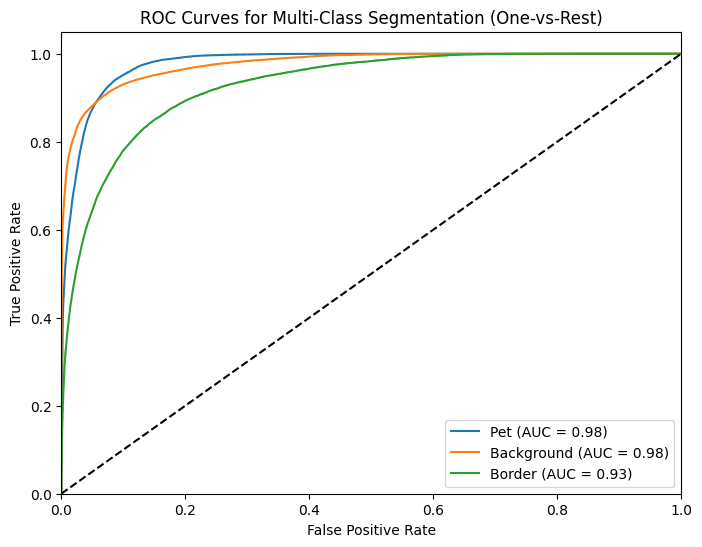

In [ ]:
def calculate_iou(y_true, y_pred, num_classes=3):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return jaccard_score(y_true, y_pred, average=None, labels=range(num_classes))

def calculate_roc_per_class(y_true, y_pred, num_classes=3):
    fpr = {}
    tpr = {}
    roc_auc = {}
    y_true = y_true.flatten()
    y_pred = y_pred.reshape(-1, num_classes)

    for i in range(num_classes):
        y_true_binary = (y_true == i).astype(np.int32)
        y_pred_binary = y_pred[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_binary)
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

test_images, test_masks = next(iter(test_dataset))
predictions = model.predict(test_images)
pred_labels = predictions.argmax(axis=-1)

iou_scores = calculate_iou(test_masks.numpy(), pred_labels)
print("IoU scores per class (0: pet, 1: background, 2: border):", iou_scores)
print("Mean IoU:", iou_scores.mean())

fpr, tpr, roc_auc = calculate_roc_per_class(test_masks.numpy(), predictions)
class_names = ['Pet', 'Background', 'Border']

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Segmentation (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

#**Save Model**

In [ ]:
model.save('unet_model.h5')

***Powerd By Miracle⚡***

In [ ]:
from google.colab import files
import json

# بارگذاری فایل نوت‌بوک
uploaded = files.upload()

# تغییر فایل نوت‌بوک
notebook_file = list(uploaded.keys())[0]

# باز کردن نوت‌بوک و اصلاح متادیتا
with open(notebook_file, 'r') as f:
    notebook_data = json.load(f)

# حذف متادیتا که باعث خطا شده
if 'metadata' in notebook_data:
    del notebook_data['metadata']

# ذخیره نوت‌بوک جدید
with open('fixed_' + notebook_file, 'w') as f:
    json.dump(notebook_data, f)

# دانلود فایل اصلاح شده
files.download('fixed_' + notebook_file)

Saving PetSegmentationUNet.ipynb to PetSegmentationUNet.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>